In [1]:
!pip install scikit-surprise
# %pip install kagglehub

Denne fil bliver brugt til at analysere og kigge på det datasæt vi har valgt at lave vores endelige projekt i. 



In [ ]:
import kagglehub
import os
import pandas as pd

# Download sidste version
path = kagglehub.dataset_download("dsabljic/movielens-32m")
print("Path to dataset files:", path)

# List subfolder 'ml-32m'
dataset_folder = os.path.join(path, "ml-32m")
print("Indhold i mappen ml-32m:")
print(os.listdir(dataset_folder))

# Find en csv-fil i mappen
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]



# Læs første CSV-fil (bare som eksempel)
# Læser også de andre CSV-filer, hvis de findes og gemmer dem seperat
if csv_files:
    links_csv = os.path.join(dataset_folder, csv_files[0])
    df_links = pd.read_csv(links_csv)

    movies_csv = os.path.join(dataset_folder, "movies.csv")
    df_movies = pd.read_csv(movies_csv)

    ratings_csv = os.path.join(dataset_folder, "ratings.csv")
    df_ratings = pd.read_csv(ratings_csv)

    tags_csv = os.path.join(dataset_folder, "tags.csv")
    df_tags = pd.read_csv(tags_csv)
    
else:
    print("Ingen CSV-filer fundet i mappen.")

# kombiner datafiler til en enkelt DataFrame
# df = pd.merge(df_ratings, df_movies, on='movieId', how='left')
# df = pd.merge(df, df_links, on='movieId', how='left')
# print("DataFrame med ratings og movie info:")
# print(df.head())
# print("Antal rækker i DataFrame:", len(df))


Path to dataset files: C:\Users\eriks\.cache\kagglehub\datasets\dsabljic\movielens-32m\versions\1
Indhold i mappen ml-32m:
['checksums.txt', 'links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']
DataFrame med ratings og movie info:
   userId  movieId  rating  timestamp  \
0       1       17     4.0  944249077   
1       1       25     1.0  944250228   
2       1       29     2.0  943230976   
3       1       30     5.0  944249077   
4       1       32     5.0  943228858   

                                               title  \
0                       Sense and Sensibility (1995)   
1                           Leaving Las Vegas (1995)   
2  City of Lost Children, The (Cité des enfants p...   
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                                   genres  
0                           Drama|Romance  
1                           Drama|Romance  
2  Adventure|Drama|Fantasy|Mystery|Sci

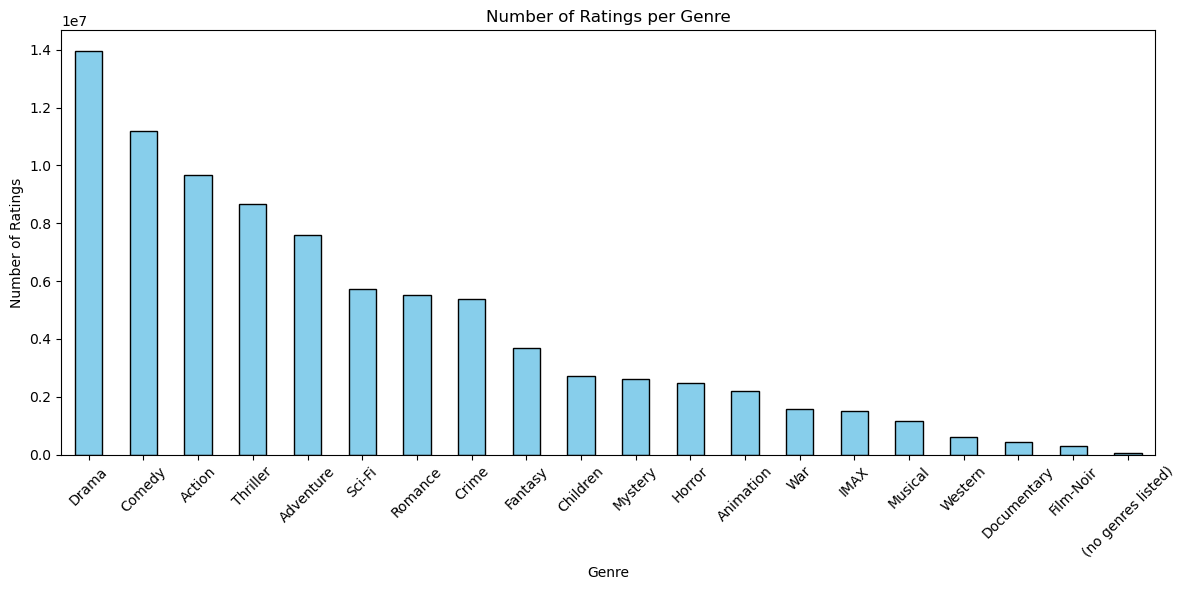

In [ ]:
import matplotlib.pyplot as plt
# Load the data
# ratings = pd.read_csv('ratings.csv')
# movies = pd.read_csv('movies.csv')

# Merge ratings with movies to get genres
# Merger "ratings" med "movies" for at få genrerne
ratings_with_genres = pd.merge(df_ratings, df_movies, on='movieId')

# Splitter genres som er adsiklt med "<pipe>" og udvider til individuelle rækker
ratings_with_genres['genres'] = ratings_with_genres['genres'].str.split('|')
ratings_exploded = ratings_with_genres.explode('genres')

# Tæller antallet af ratings pr. genre
genre_counts = ratings_exploded['genres'].value_counts().sort_values(ascending=False)

# Plotter ratings som et søjlediagram
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Ratings per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

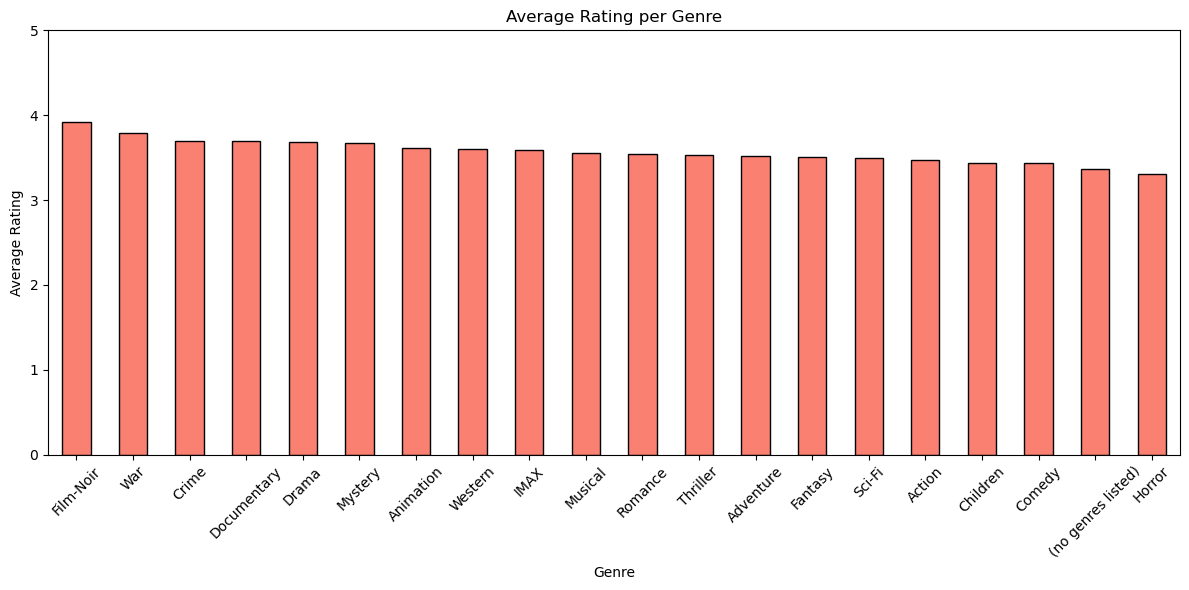

In [ ]:

# Grupperer efter genre og beregner gennemsnitlig rating
genre_avg_ratings = ratings_exploded.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Plotter gennemsnitlig rating pr. genre som et søjlediagram
plt.figure(figsize=(12, 6))
genre_avg_ratings.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

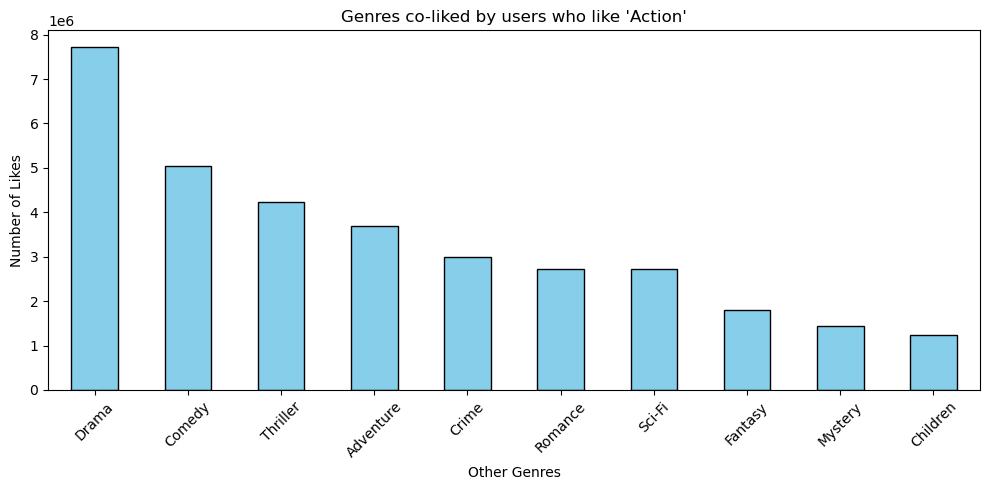

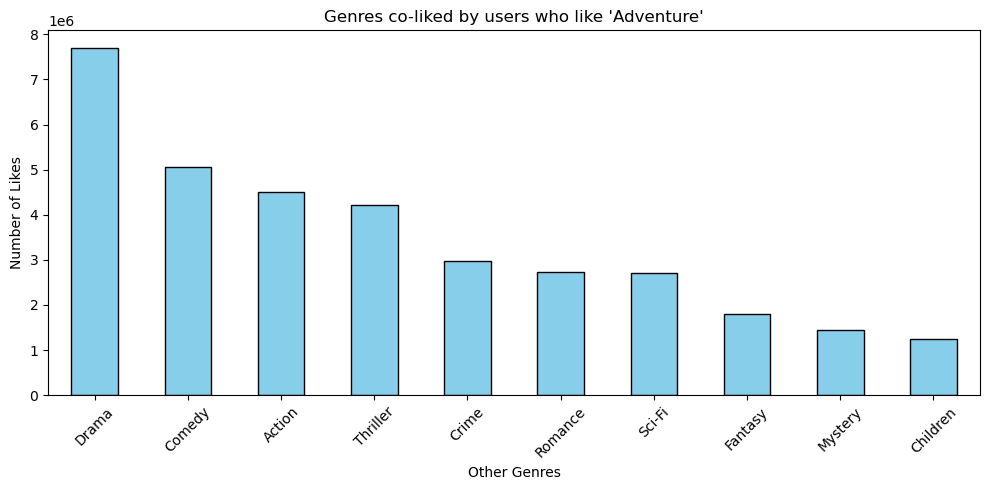

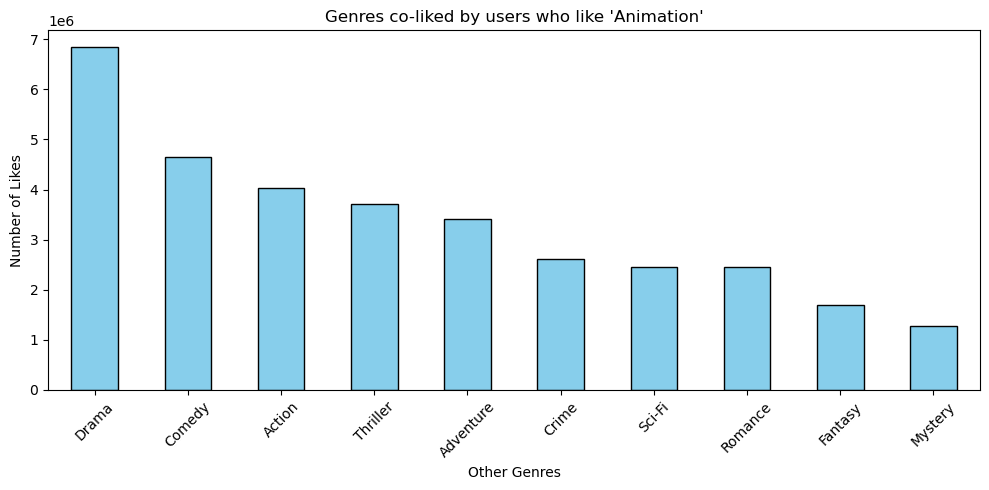

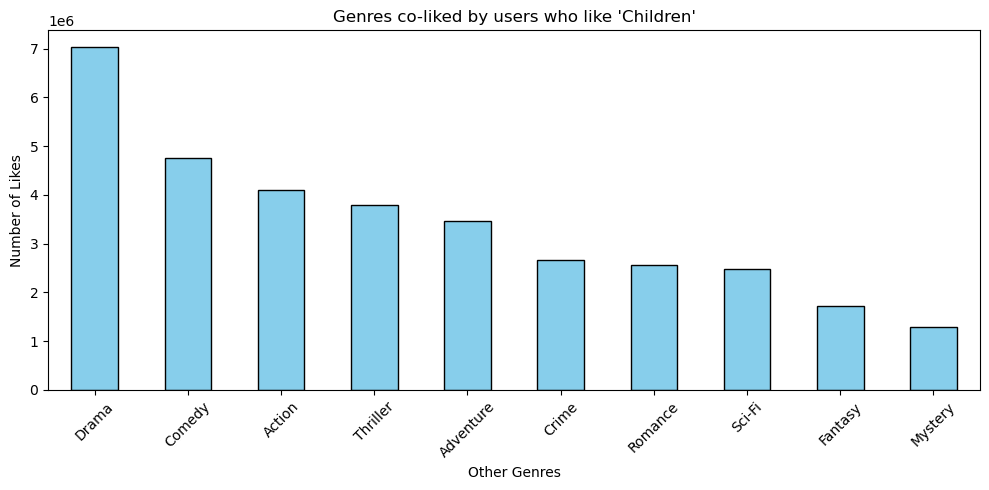

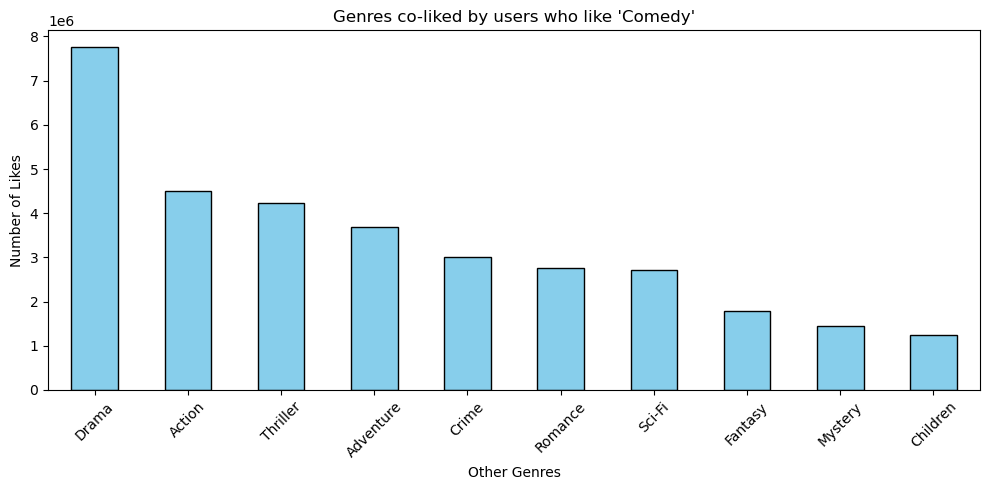

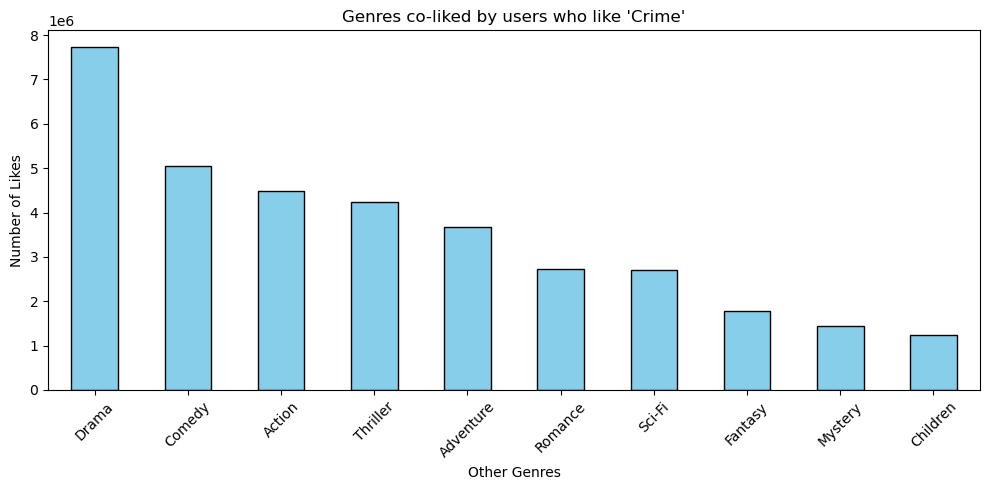

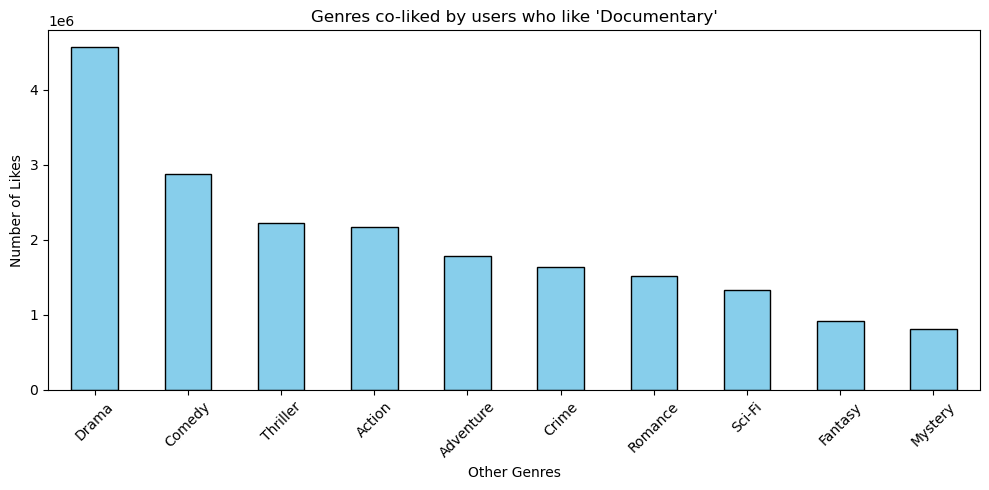

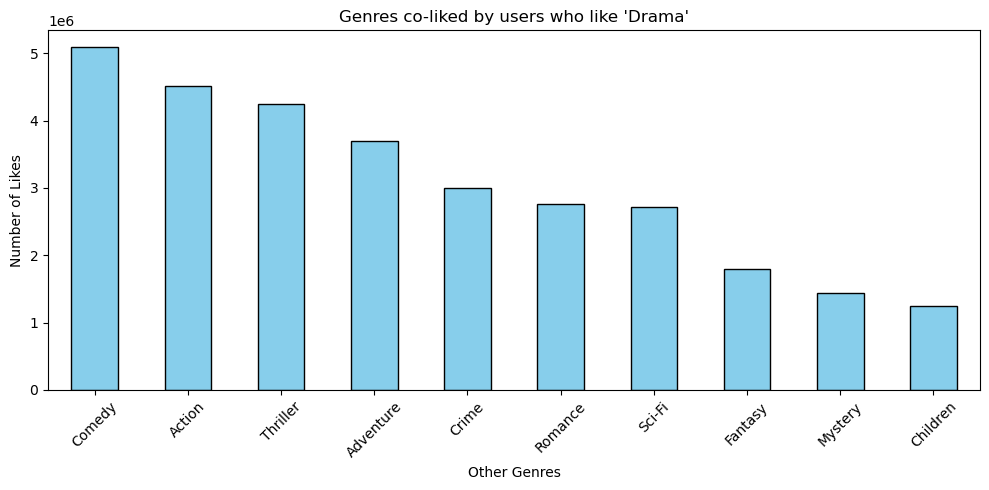

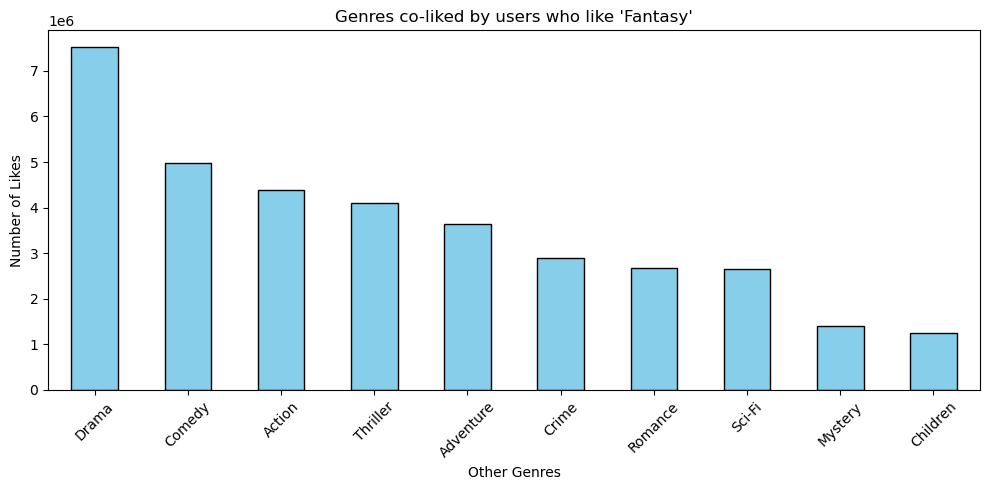

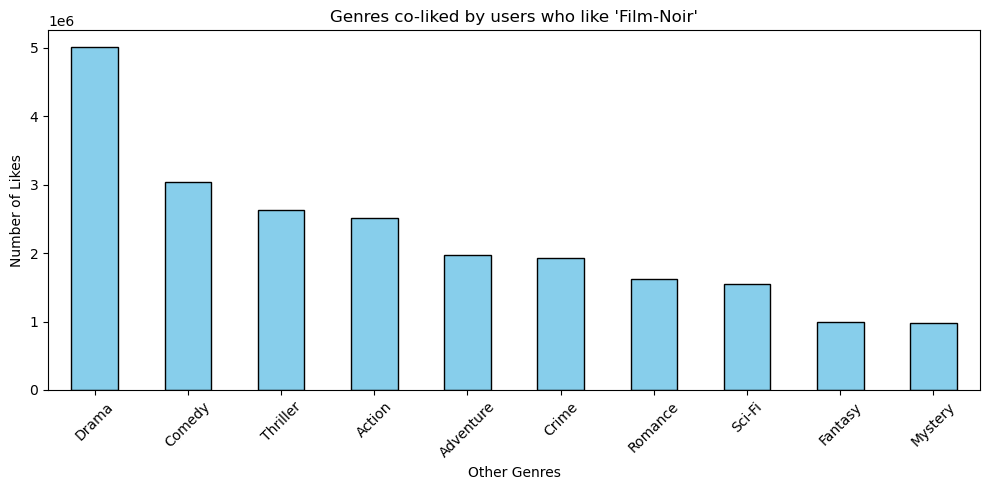

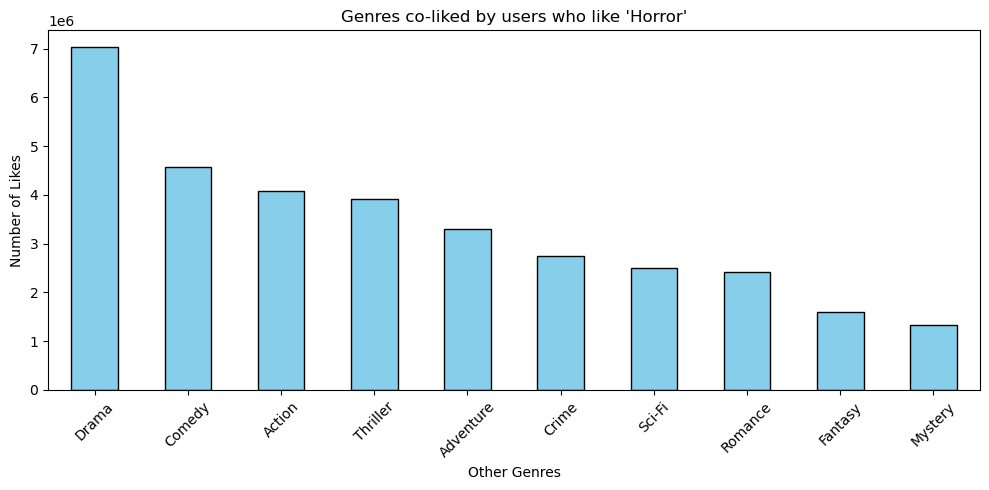

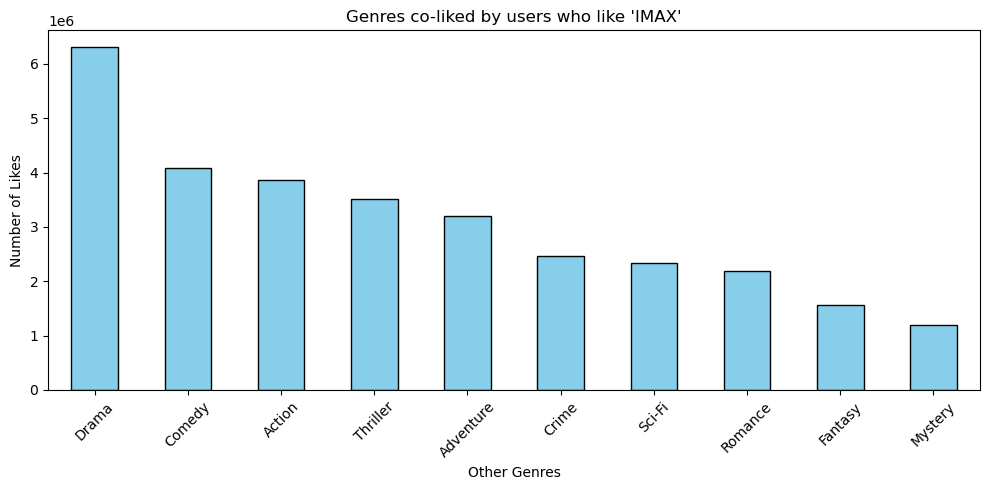

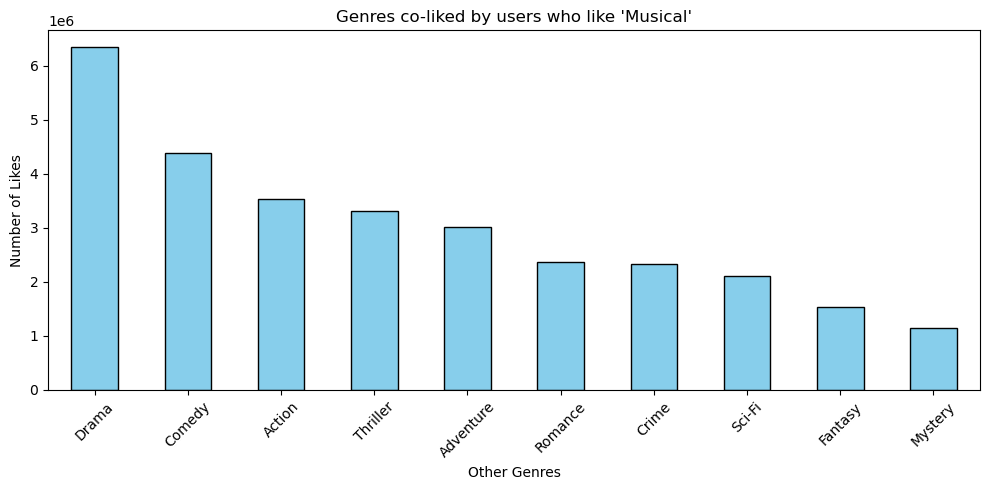

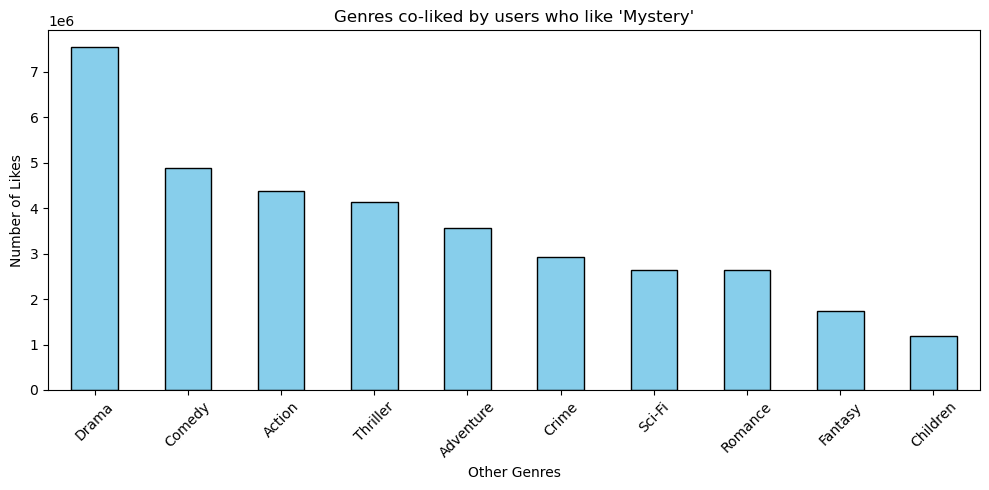

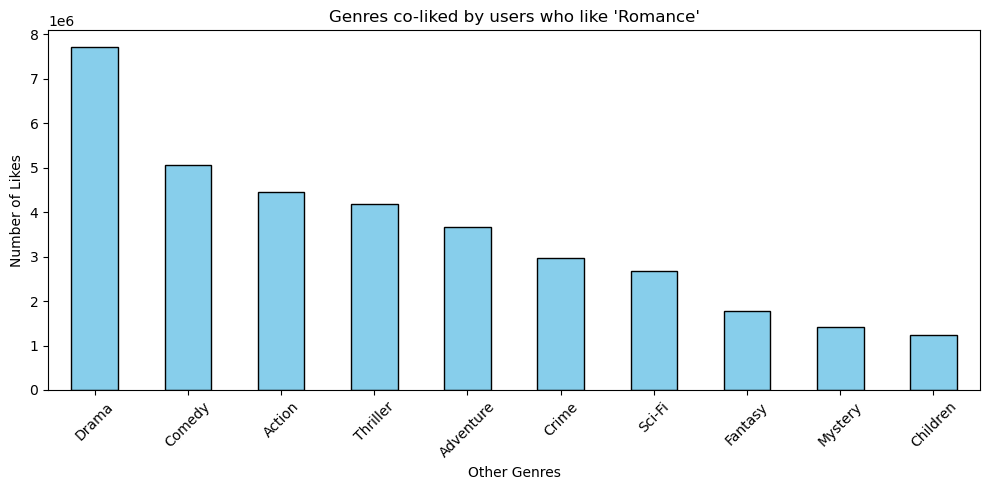

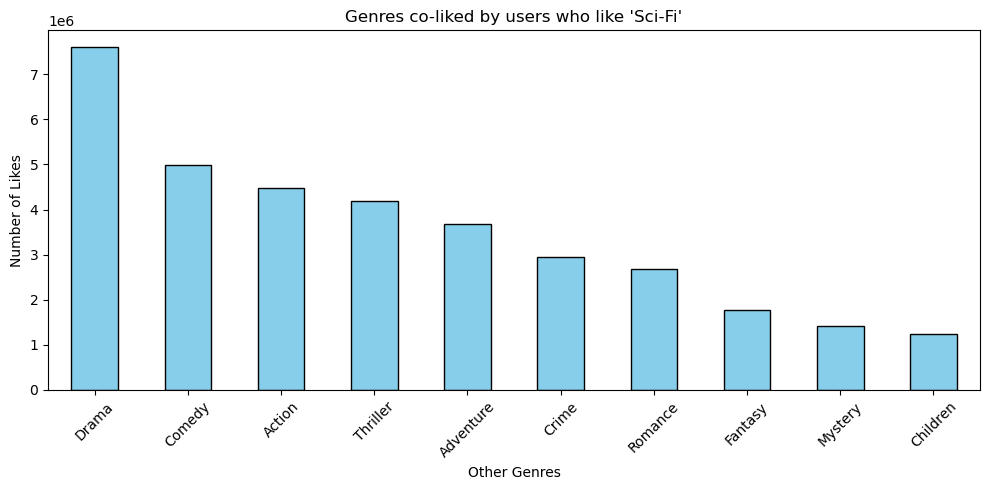

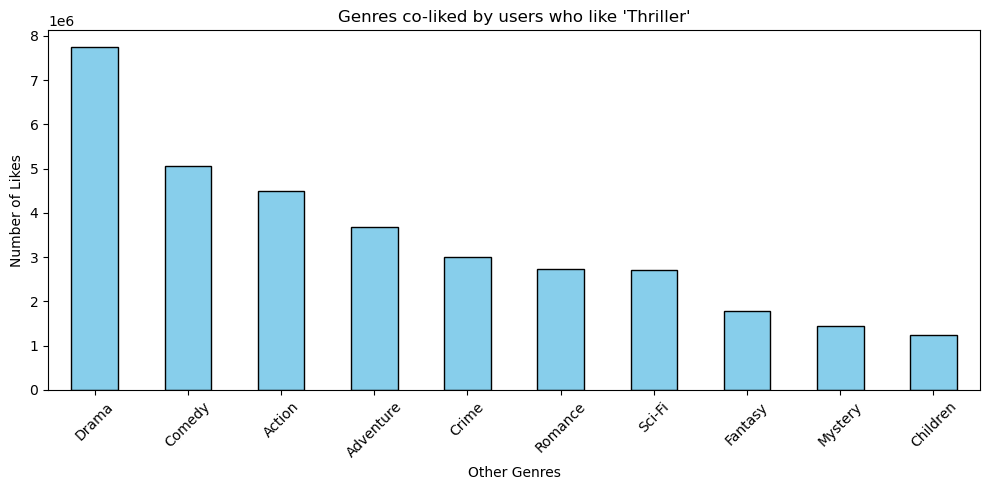

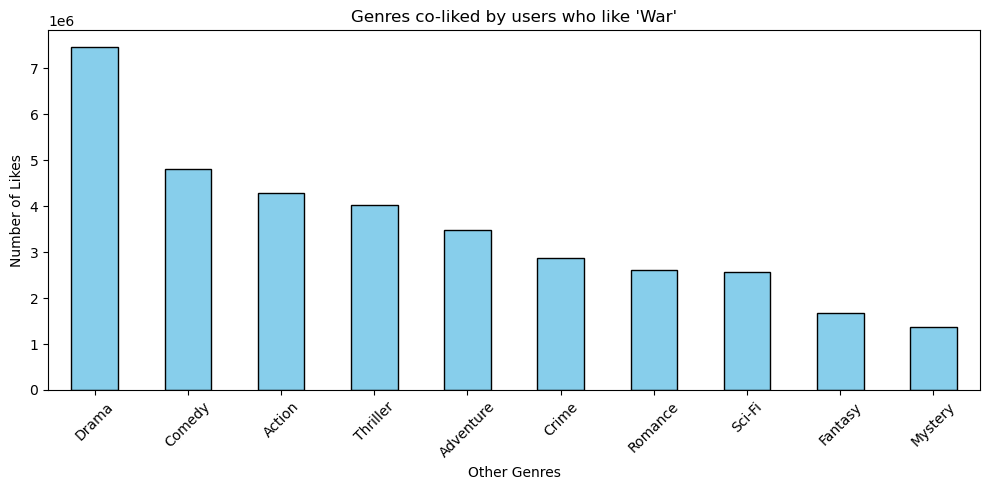

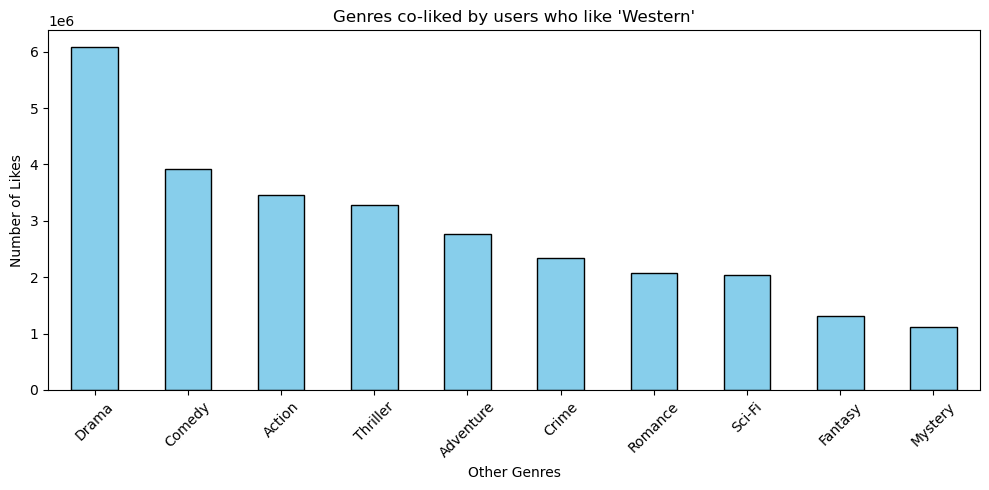

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Define liking as rating >= 4
# Definerer "liked" som rating >= 4
liked = ratings_exploded[ratings_exploded['rating'] >= 4.0]

# Henter alle unikke genrer fra ratings_exploded
all_genres = sorted(set(g for sublist in df_movies['genres'].str.split('|') for g in sublist if g != '(no genres listed)'))

# For hver genre, find de andre genrer som brugerne også kan lide
for genre in all_genres:
    # Brugere der kan lide denne genre
    users_who_liked_genre = liked[liked['genres'] == genre]['userId'].unique()
    
    # Hent ratings fra disse brugere
    ratings_by_these_users = liked[liked['userId'].isin(users_who_liked_genre)]
    
    # Tæller de genrer som disse brugere også kan lide
    co_liked_counts = ratings_by_these_users['genres'].value_counts().drop(genre, errors='ignore').sort_values(ascending=False)
    
    # Plot i søjlediagram
    plt.figure(figsize=(10, 5))
    co_liked_counts.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Genres co-liked by users who like '{genre}'")
    plt.xlabel("Other Genres")
    plt.ylabel("Number of Likes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import pandas as pd


# Klargør data til Surprise (kræver userId, itemId, rating kolonner)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

# Del dataen ind i trænings- og test-sæt
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Definer model
model = SVD()

# Træn model
model.fit(trainset)

# Forudsig ratings for testset
predictions = model.test(testset)

# Evaluer performance af modellen
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))

# Show some example predictions
# Vis eksmepler på forudsigelser
print("\nExample predictions:")
for pred in predictions[:10]:
    print(f"User {pred.uid} → Movie {pred.iid} | True: {pred.r_ui:.1f} | Predicted: {pred.est:.2f}")


RMSE: 0.7718
RMSE: 0.771786405890967
MAE:  0.5800
MAE: 0.5799593527362376

Example predictions:
User 157024 → Movie 2949 | True: 3.5 | Predicted: 3.74
User 120367 → Movie 6378 | True: 4.5 | Predicted: 4.41
User 43797 → Movie 176423 | True: 5.0 | Predicted: 3.56
User 29008 → Movie 3202 | True: 4.0 | Predicted: 2.94
User 11864 → Movie 3267 | True: 4.0 | Predicted: 3.78
User 55714 → Movie 8961 | True: 4.0 | Predicted: 4.19
User 126000 → Movie 50 | True: 3.5 | Predicted: 3.92
User 183292 → Movie 2770 | True: 2.5 | Predicted: 3.34
User 159884 → Movie 1 | True: 4.5 | Predicted: 3.96
User 62021 → Movie 1250 | True: 5.0 | Predicted: 4.55


In [ ]:
from surprise import SVD, NMF, KNNBasic, BaselineOnly
from surprise.model_selection import train_test_split
from surprise import accuracy

# Filtrerer til de 1000 brugere mest flest ratings
top_users = df_ratings['userId'].value_counts().nlargest(1000).index
df_small = df_ratings[df_ratings['userId'].isin(top_users)]

# Derefter bruger df_small i Dataset.load_from_df(...)

# Liste over algoritmer der skal testes for at finde den bedste
algorithms = {
    "SVD": SVD(),
    "NMF": NMF(),
    "KNNBasic": KNNBasic(),
    "BaselineOnly": BaselineOnly()
}

# Forbered data for Suprise (kræver userId, itemId, rating kolonner)
reader = Reader(rating_scale=(0.5, 5.0))
data_small = Dataset.load_from_df(df_small[['userId', 'movieId', 'rating']], reader)

# Del dataen ind i trænings- og test-sæt
trainset, testset = train_test_split(data_small, test_size=0.2, random_state=42)

#Evaluer algoritmerne
results = []
for name, algo in algorithms.items():
    algo.fit(trainset)
    preds = algo.test(testset)
    rmse = accuracy.rmse(preds, verbose=False)
    mae = accuracy.mae(preds, verbose=False)
    results.append((name, rmse, mae))

# Print resultaterne
print("\nModel Performance Comparison:")
for name, rmse, mae in results:
    print(f"{name:15} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Model Performance Comparison:
SVD             | RMSE: 0.7472 | MAE: 0.5593
NMF             | RMSE: 0.8269 | MAE: 0.6270
KNNBasic        | RMSE: 0.8619 | MAE: 0.6488
BaselineOnly    | RMSE: 0.8202 | MAE: 0.6228


In [ ]:
from surprise.model_selection import GridSearchCV

# Definer parameter grid for NMF
param_grid = {
    'n_factors': [15, 30, 50],     # Number of latent features
    'reg_pu': [0.06, 0.1],         # Regularization for users
    'reg_qi': [0.06, 0.1],         # Regularization for items
    'biased': [True, False]        # Include user/item bias
}

# Kør Grid Search for at finde de bedste hyperparametre
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=1)
gs.fit(data_small)

# Print de bedste resultater
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])


Best RMSE score: 0.8354457105660872
Best parameters: {'n_factors': 50, 'reg_pu': 0.1, 'reg_qi': 0.1, 'biased': False}


In [ ]:
from surprise import NMF, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Klargør det fulde dataset for Surprise (kræver userId, itemId, rating kolonner)
reader = Reader(rating_scale=(0.5, 5.0))
data_full = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

# Del dataen ind i trænings- og test-sæt
trainset, testset = train_test_split(data_full, test_size=0.2, random_state=42)

# Træn NMF med de bedste hyperparametre fra Grid Search
nmf_best = NMF(
    n_factors=50,
    reg_pu=0.1,
    reg_qi=0.1,
    biased=False,
    random_state=42
)

# Fit og evaluer
nmf_best.fit(trainset)
predictions = nmf_best.test(testset)

# Print RMSE og MAE for det fulde dataset
print("Final RMSE on full dataset:", accuracy.rmse(predictions))
print("Final MAE on full dataset:", accuracy.mae(predictions))


RMSE: 0.8585
Final RMSE on full dataset: 0.8584536710727777
MAE:  0.6483
Final MAE on full dataset: 0.6482587418389769


In [ ]:
from surprise import NMF, Dataset, Reader
import pandas as pd

# Your liked movies (update with your actual preferences)
# Dine foretrukne film (opdater disse med dine faktiske præferencer)
liked_movies = {
    1: 5.0,   # MovieID 1 rated 5.0
    50: 4.5,  # MovieID 50 rated 4.5
    100: 4.0, # MovieID 100 rated 4.0
}

# Tilføjer nyt unikt bruger ID
user_id = 999999  

# Tilføjer dine ratings til den originale ratings DataFrame
df_liked = pd.DataFrame([(user_id, movieId, rating) for movieId, rating in liked_movies.items()],
                        columns=["userId", "movieId", "rating"])
df_custom = pd.concat([df_ratings, df_liked], ignore_index=True)

# Forbered ratings og movies data
reader = Reader(rating_scale=(0.5, 5.0))
data_custom = Dataset.load_from_df(df_custom[['userId', 'movieId', 'rating']], reader)

# Byg træningssæt og træn NMF model
trainset_custom = data_custom.build_full_trainset()

nmf_custom = NMF(
    n_factors=50,
    reg_pu=0.1,
    reg_qi=0.1,
    biased=False,
    random_state=42
)
nmf_custom.fit(trainset_custom)

# Anbefalede film som ikke er vurderet af den bruger
all_movie_ids = df_movies['movieId'].unique()
rated_movie_ids = set(liked_movies.keys())
unrated_movie_ids = [mid for mid in all_movie_ids if mid not in rated_movie_ids]


# Forudsig ratings for de film som ikke er vurderet af brugeren
predictions = [nmf_custom.predict(user_id, mid) for mid in unrated_movie_ids]


# Få top 10 anbefalinger
top_preds = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]


# Vis resultaterne
print("\nTop NMF-Based Recommendations:")
for pred in top_preds:
    title = df_movies[df_movies['movieId'] == int(pred.iid)]['title'].values[0]
    print(f"{title} → Predicted rating: {pred.est:.2f}")



Top NMF-Based Recommendations:
Before the Rain (Pred dozhdot) (1994) → Predicted rating: 5.00
Shawshank Redemption, The (1994) → Predicted rating: 5.00
Song of the Little Road (Pather Panchali) (1955) → Predicted rating: 5.00
Godfather, The (1972) → Predicted rating: 5.00
It Happened One Night (1934) → Predicted rating: 5.00
North by Northwest (1959) → Predicted rating: 5.00
Casablanca (1942) → Predicted rating: 5.00
Notorious (1946) → Predicted rating: 5.00
Thin Man, The (1934) → Predicted rating: 5.00
Paths of Glory (1957) → Predicted rating: 5.00
